## Import Libararies

In [2]:
# Libaries for Neural Network
import tensorflow as tf

# Libraries for distributed computation
import pyarrow.hdfs as hdfs
from pyspark.sql import SparkSession
import os

# Libraries for preprocessing images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-10-12 01:39:12.820288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-12 01:39:12.843488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-12 01:39:12.850171: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-12 01:39:12.867103: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-12 01:39:14.069467: W tensorflow/compiler/tf2tens

In [3]:

# Libaries for graph
import matplotlib.pyplot as plt

# Libraries for logs and results 
from tensorflow.keras.callbacks import TensorBoard # this is for showing the graphs in live
import datetime


## EDA

### Load images from hadoop

In [4]:
# get connection with HDFS
hdfs_client = hdfs.connect('localhost', 9000)  # computer, port

/tmp/ipykernel_76688/403074299.py:2: FutureWarning: pyarrow.hdfs.connect is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  hdfs_client = hdfs.connect('localhost', 9000)  # computer, port
2024-10-12 01:39:20,829 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# path from hadoop
train_path = '/data/train/'
valid_path = '/data/valid/'
test_path = '/data/test/'

# path for download images 
local_train_path = '/home/hduser/local/train/'  # path for train
local_test_path = '/home/hduser/local/test/'  # path for test
local_valid_path = '/home/hduser/local/valid/'  # path for valid

### Function for download images from hadoop

In [6]:
def copy_images_from_hdfs(hdfs_client, hdfs_image_path, local_image_path):
    # list files from HDFS
    files = hdfs_client.ls(hdfs_image_path)
    
    # Create a directory local if does not exist 
    os.makedirs(local_image_path, exist_ok=True)
    
    # Copy ceach file to directory local
    for file in files:
        local_file_path = os.path.join(local_image_path, os.path.basename(file))
        with hdfs_client.open(file) as hdfs_file:
            with open(local_file_path, 'wb') as local_file:
                local_file.write(hdfs_file.read())

### Copy from HDFS

In [8]:
# Copy images
copy_images_from_hdfs(hdfs_client, train_path, local_train_path)

In [9]:
copy_images_from_hdfs(hdfs_client, test_path, local_test_path)

In [10]:
copy_images_from_hdfs(hdfs_client, valid_path, local_valid_path)

### Load CSV from hadoop with Spark

In [11]:
# Create spark session
spark = SparkSession.builder \
    .appName("CariesRecognitionWithSpark") \
    .getOrCreate()

24/10/12 01:42:47 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [13]:
# path from hadoop
train_dir = '/data/train/annotations.csv'
valid_dir = '/data/valid/annotations.csv'
test_dir = '/data/test/annotations.csv'

### Load and show Data

In [14]:
train_csv = spark.read.csv(train_dir, header='true')
train_csv.createOrReplaceTempView("train_data")
train_csv.show()

+--------------------+-----+------+--------+----+----+----+----+
|            filename|width|height|   class|xmin|ymin|xmax|ymax|
+--------------------+-----+------+--------+----+----+----+----+
|0674_jpg.rf.e02a1...|  512|   256| Implant| 175| 116| 206| 153|
|0674_jpg.rf.e02a1...|  512|   256|Fillings| 170| 109| 189| 133|
|0674_jpg.rf.e02a1...|  512|   256| Implant| 221| 124| 257| 178|
|0674_jpg.rf.e02a1...|  512|   256| Implant| 302| 126| 329| 175|
|0674_jpg.rf.e02a1...|  512|   256| Implant| 335| 114| 360| 154|
|0674_jpg.rf.e02a1...|  512|   256|Fillings| 358|  57| 391| 106|
|0674_jpg.rf.e02a1...|  512|   256|Fillings| 330|  81| 358| 106|
|0674_jpg.rf.e02a1...|  512|   256|Fillings| 311|  58| 330| 109|
|0674_jpg.rf.e02a1...|  512|   256| Implant| 142|  96| 174| 144|
|0674_jpg.rf.e02a1...|  512|   256|Fillings| 257| 127| 282| 154|
|0674_jpg.rf.e02a1...|  512|   256|Fillings| 282| 130| 302| 150|
|0674_jpg.rf.e02a1...|  512|   256|Fillings| 319| 120| 338| 147|
|0674_jpg.rf.e02a1...|  5

In [15]:
test_csv = spark.read.csv(test_dir, header='true')
test_csv.createOrReplaceTempView("test_data")
test_csv.show()

+--------------------+-----+------+--------+----+----+----+----+
|            filename|width|height|   class|xmin|ymin|xmax|ymax|
+--------------------+-----+------+--------+----+----+----+----+
|0136_jpg.rf.03e2a...|  512|   256| Implant| 195| 169| 209| 212|
|0136_jpg.rf.03e2a...|  512|   256| Implant| 288| 171| 301| 205|
|0136_jpg.rf.03e2a...|  512|   256| Implant| 203| 107| 217| 150|
|0136_jpg.rf.03e2a...|  512|   256| Implant| 287| 104| 302| 150|
|0136_jpg.rf.03e2a...|  512|   256| Implant| 301| 103| 312| 150|
|0136_jpg.rf.03e2a...|  512|   256|Fillings| 164| 158| 195| 197|
|0136_jpg.rf.03e2a...|  512|   256|Fillings| 322| 159| 355| 200|
|0136_jpg.rf.03e2a...|  512|   256|Fillings| 300| 159| 330| 206|
|0136_jpg.rf.03e2a...|  512|   256|Fillings| 331| 111| 354| 150|
|0136_jpg.rf.03e2a...|  512|   256|Fillings| 310| 110| 332| 152|
|0136_jpg.rf.03e2a...|  512|   256|Fillings| 185| 111| 204| 152|
|0136_jpg.rf.03e2a...|  512|   256|Fillings| 209| 160| 223| 202|
|0136_jpg.rf.03e2a...|  5

In [16]:
valid_csv = spark.read.csv(valid_dir, header='true')
valid_csv.createOrReplaceTempView("valid_data")
valid_csv.show()

+--------------------+-----+------+--------+----+----+----+----+
|            filename|width|height|   class|xmin|ymin|xmax|ymax|
+--------------------+-----+------+--------+----+----+----+----+
|0355_jpg.rf.e3e6d...|  512|   256|Fillings| 186|  85| 209| 129|
|0355_jpg.rf.e3e6d...|  512|   256|Fillings| 167|  93| 188| 128|
|0355_jpg.rf.e3e6d...|  512|   256|Fillings| 143|  93| 170| 130|
|0355_jpg.rf.e3e6d...|  512|   256|Fillings| 127| 132| 155| 182|
|0355_jpg.rf.e3e6d...|  512|   256| Implant| 313|  85| 330| 123|
|0355_jpg.rf.e3e6d...|  512|   256|Fillings| 156| 133| 181| 182|
|0355_jpg.rf.e3e6d...|  512|   256|Fillings| 315| 129| 331| 172|
|0355_jpg.rf.e3e6d...|  512|   256|Fillings| 355| 125| 379| 170|
|0355_jpg.rf.e3e6d...|  512|   256|Fillings| 331| 126| 355| 176|
|0640_jpg.rf.efc8c...|  512|   256| Implant| 275|  95| 293| 134|
|0640_jpg.rf.efc8c...|  512|   256| Implant| 292|  94| 306| 132|
|0640_jpg.rf.efc8c...|  512|   256|Fillings| 344| 147| 377| 192|
|0640_jpg.rf.efc8c...|  5

#### Transform data to dataframe 

In [17]:
train_csv = train_csv.toPandas()

In [18]:
test_csv = test_csv.toPandas()

In [19]:
valid_csv = valid_csv.toPandas()

## Verify if there are data lost between Csv and images

In [20]:
# Verify images in the directory
for filename in train_csv['filename']:
    file_path = os.path.join(local_train_path, filename)
    if not os.path.exists(file_path):
        print(f"file did not find: {file_path}")

In [21]:
for filename in test_csv['filename']:
    file_path = os.path.join(local_test_path, filename)
    if not os.path.exists(file_path):
        print(f"file did not find: {file_path}")

In [22]:
for filename in valid_csv['filename']:
    file_path = os.path.join(local_valid_path, filename)
    if not os.path.exists(file_path):
        print(f"file did not find: {file_path}")

### Charge images and transform to tensorflow

In [24]:
datagen = ImageDataGenerator(rescale=1./255)

In [25]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_csv,
    directory=local_train_path,
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'  # Cambiado a 'categorical' para múltiples clases
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_csv,
    directory=local_valid_path,
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'  # Cambiado a 'categorical' para múltiples clases
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_csv,
    directory=local_test_path,
    x_col='filename',
    y_col=None,
    target_size=(150, 150),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 8030 validated image filenames belonging to 4 classes.
Found 780 validated image filenames belonging to 4 classes.
Found 473 validated image filenames.


### Show images from trainng

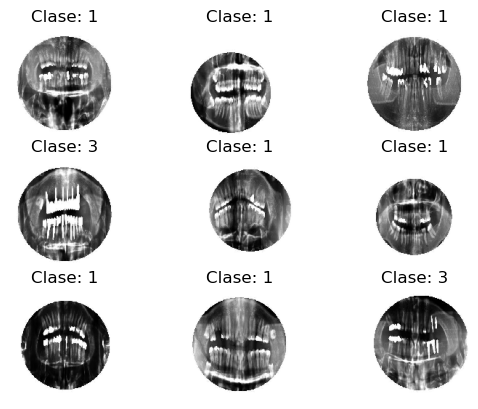

In [22]:
def show_images(generator):
    x_batch, y_batch = next(generator)
    for i in range(0, 9):                
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i])
        plt.title(f'Clase: {y_batch[i].argmax()}')  # Mostrar la clase de la imagen
        plt.axis('off')
    plt.show()    
    

show_images(train_generator)

# Defining Models

In [26]:
def create_simple_model():# ANN
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(150, 150, 3)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [27]:
def create_cnn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [28]:
def create_rnn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), input_shape=(None, 150, 150, 3)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2, 2))),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## Configurate TensorBoard for showing the learning

In [26]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

## Training models using TensorBoard:

In [29]:
simple_model = create_simple_model()
history_simple = simple_model.fit(train_generator, validation_data=valid_generator, epochs=10, callbacks=[tensorboard_callback])

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.4908 - loss: 23.9407 - val_accuracy: 0.5090 - val_loss: 2.2703
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 40s 156ms/step - accuracy: 0.5595 - loss: 5.1583 - val_accuracy: 0.4064 - val_loss: 2.4423
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 40s 155ms/step - accuracy: 0.5758 - loss: 2.9759 - val_accuracy: 0.6859 - val_loss: 2.9018
Epoch 4/10
 30/251 ━━━━━━━━━━━━━━━━━━━━ 31s 144ms/step - accuracy: 0.6037 - loss: 2.4612

KeyboardInterrupt: 

In [28]:
cnn_model = create_cnn_model()
history_cnn = cnn_model.fit(train_generator, validation_data=valid_generator, epochs=10, callbacks=[tensorboard_callback])

/home/hduser/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 149s 581ms/step - accuracy: 0.6211 - loss: 1.0420 - val_accuracy: 0.7077 - val_loss: 0.8392
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 148s 587ms/step - accuracy: 0.6898 - loss: 0.8017 - val_accuracy: 0.6603 - val_loss: 0.8826
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 145s 576ms/step - accuracy: 0.7112 - loss: 0.7056 - val_accuracy: 0.6846 - val_loss: 0.8547
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 131s 520ms/step - accuracy: 0.7333 - loss: 0.6545 - val_accuracy: 0.6949 - val_loss: 0.8538
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 118s 469ms/step - accuracy: 0.7401 - loss: 0.6216 - val_accuracy: 0.6705 - val_loss: 0.9374
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 119s 471ms/step - accuracy: 0.7428 - loss: 0.5960 - val_accuracy: 0.7179 - val_loss: 0.8805
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 126s 501ms/step - accuracy: 0.7458 - loss: 0.5793 - val_accuracy: 0.6551 - val_loss: 0.9081
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 157s 562ms/step - accuracy: 0.7533 -

In [30]:
#rnn_model = create_rnn_model()
#history_rnn = rnn_model.fit(train_generator, validation_data=valid_generator, epochs=10, callbacks=[tensorboard_callback])

# Showing results

In [31]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

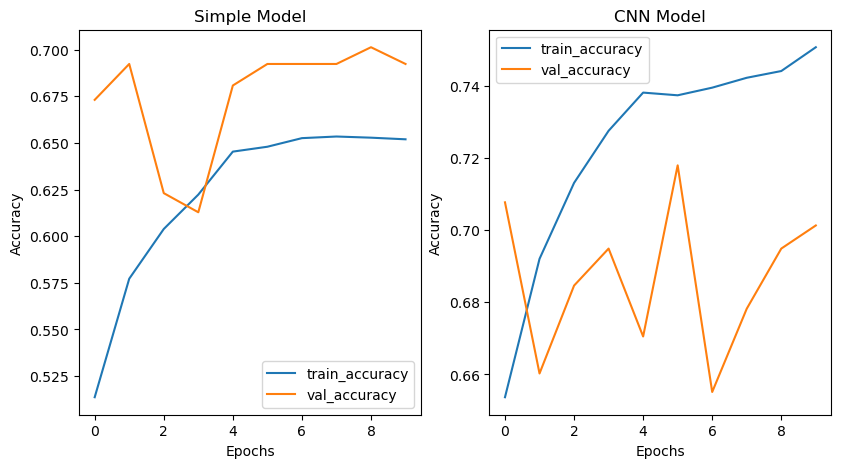

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
/usr/local/spark/python/pyspark/context.py:654: RuntimeWarning: Unable to cleanly shutdown Spark JVM process. It is possible that the process has crashed, been killed or may also be

In [32]:
def plot_learning_curves(histories, titles):
    plt.figure(figsize=(15, 5))
    for i, history in enumerate(histories):
        plt.subplot(1, 3, i+1)
        plt.plot(history.history['accuracy'], label='train_accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.title(titles[i])
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
    plt.show()

plot_learning_curves([history_simple, history_cnn], ['Simple Model', 'CNN Model'])